# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [1]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

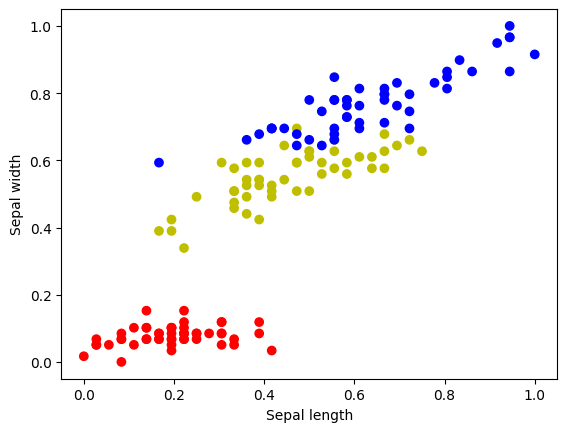

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [4]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [5]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [6]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.5287,  0.6189],
                      [-0.5016, -0.4559],
                      [ 0.6962, -0.0127]])),
             ('bias', tensor([-0.0232, -0.2205,  0.2725]))])

### Fazendo um predict

In [7]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[-0.0987, -0.3628,  0.4264],
        [-0.0694, -0.3350,  0.3877],
        [-0.0505, -0.2994,  0.3492],
        [-0.0148, -0.3009,  0.3295]], grad_fn=<AddmmBackward0>)

In [8]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.2891, 0.2220, 0.4888],
        [0.2989, 0.2291, 0.4720],
        [0.3057, 0.2384, 0.4559],
        [0.3162, 0.2376, 0.4462]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [9]:
F.softmax(out,dim=1)*100

tensor([[28.9144, 22.2027, 48.8829],
        [29.8854, 22.9139, 47.2007],
        [30.5715, 23.8350, 45.5935],
        [31.6242, 23.7557, 44.6201]], grad_fn=<MulBackward0>)

### Predição da classe

In [10]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([2, 2, 2, 2])
tensor([0.4888, 0.4720, 0.4559, 0.4462], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [11]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [12]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.20858094096183777


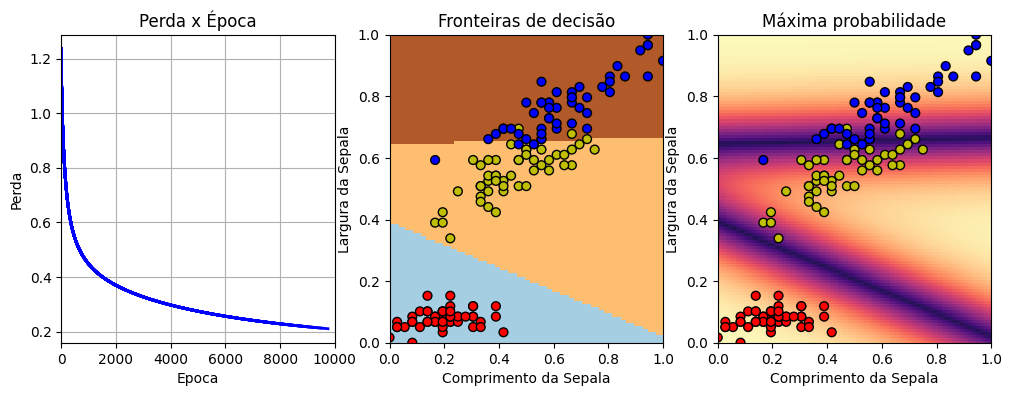

In [13]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [14]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.4047, -14.5153],
                      [  1.7409,  -0.6115],
                      [  1.3298,  15.2771]])),
             ('bias', tensor([ 7.0381,  1.5981, -8.6074]))])

### Salvando os parâmetros treinados

In [15]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [16]:
! ls ../models/

RegrLog_Iris.pt


In [17]:
nn.init.constant(model.weight,0)
model.state_dict()

<ipython-input-17-0d5512203613>:1: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 7.0381,  1.5981, -8.6074]))])

### Recuperando os pesos salvos

In [18]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.4047, -14.5153],
                      [  1.7409,  -0.6115],
                      [  1.3298,  15.2771]])),
             ('bias', tensor([ 7.0381,  1.5981, -8.6074]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [19]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.9533333333333334


### Matriz de confusão

In [20]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,46,3
2,0,4,47


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

* É necessário reinicializar os parâmetros do modelo, chamando novamente o método de inicialização dos parâmetros antes de começar o treinamento.

In [21]:
model = nn.Linear(2, 3)
torch.nn.init.uniform_(model.weight, -0.1, 0.1)

Parameter containing:
tensor([[-0.0874,  0.0784],
        [-0.0400,  0.0964],
        [-0.0927,  0.0820]], requires_grad=True)


2. Experimente refazer o treinamento com diferentes valores de learning rate

In [23]:
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

Final loss: 0.24364374577999115


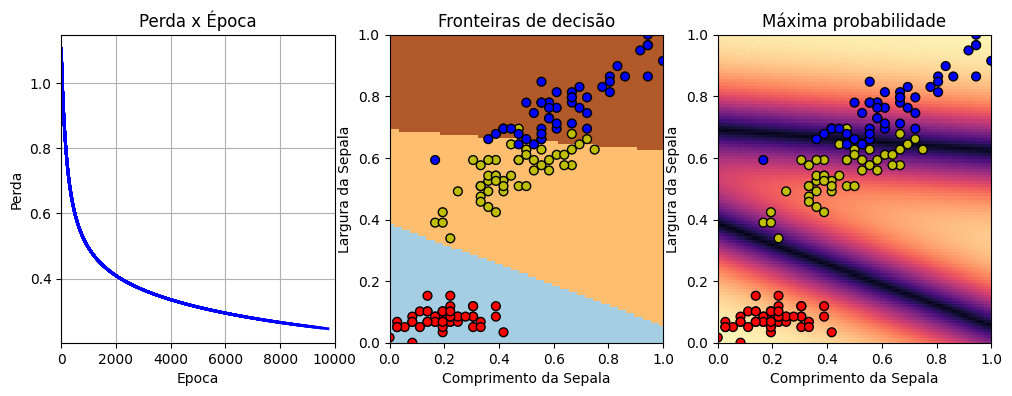

In [24]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade?
    
    2. Qual é a amostra classificada erradamente, com maior probabilidade?
    
    3. Qual é a amostra classificada corretamente, com menor probabilidade?
    4. Qual é a amostra classificada erradamente, com menor probabilidade?

In [25]:
# Predições com probabilidades
out = model(Variable(X_tensor))
prob, y_pred = torch.max(F.softmax(out, dim=1), dim=1)

# Encontrando as amostras
correctly_classified = (y_pred == Y_tensor)
incorrectly_classified = ~correctly_classified


correct_prob = prob[correctly_classified] # Probabilidades para amostras corretamente classificadas
incorrect_prob = prob[incorrectly_classified] # Probabilidades para amostras incorretamente classificadas

# Amostra classificada corretamente com maior probabilidade
max_correct_idx = correct_prob.argmax()
max_correct_sample = X_tensor[correctly_classified][max_correct_idx]
print("Amostra classificada corretamente com maior probabilidade:", max_correct_sample.numpy(), correct_prob[max_correct_idx].item())

# Amostra classificada erradamente com maior probabilidade
if incorrect_prob.nelement() > 0:
    max_incorrect_idx = incorrect_prob.argmax()
    max_incorrect_sample = X_tensor[incorrectly_classified][max_incorrect_idx]
    print("Amostra classificada erradamente com maior probabilidade:", max_incorrect_sample.numpy(), incorrect_prob[max_incorrect_idx].item())
else:
    print("Não há amostras classificadas incorretamente.")

# Amostra classificada corretamente com menor probabilidade
min_correct_idx = correct_prob.argmin()
min_correct_sample = X_tensor[correctly_classified][min_correct_idx]
print("Amostra classificada corretamente com menor probabilidade:", min_correct_sample.numpy(), correct_prob[min_correct_idx].item())

# Amostra classificada erradamente com menor probabilidade
if incorrect_prob.nelement() > 0:
    min_incorrect_idx = incorrect_prob.argmin()
    min_incorrect_sample = X_tensor[incorrectly_classified][min_incorrect_idx]
    print("Amostra classificada erradamente com menor probabilidade:", min_incorrect_sample.numpy(), incorrect_prob[min_incorrect_idx].item())
else:
    print("Não há amostras classificadas incorretamente.")


Amostra classificada corretamente com maior probabilidade: [0.         0.01694915] 0.9903584122657776
Amostra classificada erradamente com maior probabilidade: [0.16666667 0.59322035] 0.7212037444114685
Amostra classificada corretamente com menor probabilidade: [0.6944444 0.6440678] 0.5038765072822571
Amostra classificada erradamente com menor probabilidade: [0.3611111  0.66101694] 0.5146681666374207


2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?

In [26]:
# Contando os parâmetros da camada densa e de bias
num_params = sum(p.numel() for p in model.parameters())
num_dense_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_bias_params = num_params - num_dense_params

print(f"Total de parâmetros: {num_params}")
print(f"Parâmetros da camada densa: {num_dense_params}")
print(f"Parâmetros de bias: {num_bias_params}")


Total de parâmetros: 9
Parâmetros da camada densa: 9
Parâmetros de bias: 0


3. Quantas entradas e quantas saídas esta rede possui?


In [27]:
# Número de entradas e saídas
num_inputs = model.in_features
num_outputs = model.out_features

print(f"Número de entradas: {num_inputs}")
print(f"Número de saídas: {num_outputs}")


Número de entradas: 2
Número de saídas: 3


4. Como se pode calcular a acurácia a partir da matriz de confusão?


In [28]:
# Calculando a acurácia a partir da matriz de confusão
from sklearn.metrics import confusion_matrix

Y_pred = predict(model, X_tensor)
conf_matrix = confusion_matrix(Y, Y_pred)

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Acurácia: {accuracy}")

# Mostrando a matriz de confusão
print("Matriz de Confusão:")
print(pd.DataFrame(conf_matrix, columns=iris.target_names, index=iris.target_names))


Acurácia: 0.9466666666666667
Matriz de Confusão:
            setosa  versicolor  virginica
setosa          50           0          0
versicolor       0          46          4
virginica        0           4         46


5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados? - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.ma

In [29]:
input_tensor = torch.tensor([[1, 2, 3], [4, 5, 6]])
max_values, indices = torch.max(input_tensor, dim=1)

print("Valores máximos:", max_values)
print("Índices dos valores máximos:", indices)


Valores máximos: tensor([3, 6])
Índices dos valores máximos: tensor([2, 2])


## Principais aprendizados

- **Identificação de Amostras Específicas**: Aprendemos a identificar amostras classificadas corretamente e incorretamente com as maiores e menores probabilidades usando PyTorch.
- **Contagem de Parâmetros**: Vimos como contar o número total de parâmetros, incluindo os da camada densa e os de bias, em um modelo PyTorch.
- **Configuração do Modelo**: Aprendemos a verificar o número de entradas e saídas de um modelo PyTorch.
- **Cálculo de Acurácia**: Utilizamos a matriz de confusão para calcular a acurácia de um modelo.
- **Uso da Função `torch.max`**: Entendemos como a função `torch.max` funciona e quais valores ela retorna.